## Predicting Corporate Default with ML models & Sentiment Analysis

### Import libs

In [40]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.utils import resample
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
pd.options.mode.chained_assignment = None
warnings.simplefilter("ignore", ConvergenceWarning)
warnings.filterwarnings("ignore", message="X has feature names, but LogisticRegression was fitted without feature names")
warnings.filterwarnings("ignore", message="X has feature names, but RandomSurvivalForest was fitted without feature names")

### Features (Financial Ratios) Engineering Function

In [3]:

def compute_financial_ratios(df):
    # Impute missing values with the last available observation
    def impute_missing(series):
        if series.name == 'bankruptcy_dt':
            return series
        else:
            #fill forward non-bankruptcy columns
            return series.fillna(method='ffill')

    # Impute missing values for each column in the DataFrame
    df_imputed = df.apply(impute_missing)
    #fill volatility with calculated standard deviation, or ffill from previous
    df_imputed['volatility'] = df_imputed.groupby('PERMNO')['sigmaE'].transform(lambda x: x.ffill())


    # Extract necessary columns
    ni = df_imputed['ni']
    at = df_imputed['at']
    tl = df_imputed['lt']
    nwc = df_imputed['wcap']
    re = df_imputed['re']
    ebit = df_imputed['ebit']
    sale = df_imputed['sale']
    annual_return = df_imputed['RET']
    sigma = df_imputed['sigmaE']
    company_market_value = df_imputed['mktcap']

    # Create lagged features for one year
    df_imputed['ni_lag1'] = ni.shift(1)
    df_imputed['at_lag1'] = at.shift(1)
    df_imputed['lt_lag1'] = tl.shift(1)
    df_imputed['wcap_lag1'] = nwc.shift(1)
    df_imputed['re_lag1'] = re.shift(1)
    df_imputed['ebit_lag1'] = ebit.shift(1)
    df_imputed['sale_lag1'] = sale.shift(1)
    df_imputed['RET_lag1'] = annual_return.shift(1)
    df_imputed['volatility_lag1'] = sigma.shift(1)
    df_imputed['mktcap_lag1'] = company_market_value.shift(1)
    
    # Create lagged features for two years
    df_imputed['ni_lag2'] = ni.shift(2)
    df_imputed['at_lag2'] = at.shift(2)
    df_imputed['lt_lag2'] = tl.shift(2)
    df_imputed['wcap_lag2'] = nwc.shift(2)
    df_imputed['re_lag2'] = re.shift(2)
    df_imputed['ebit_lag2'] = ebit.shift(2)
    df_imputed['sale_lag2'] = sale.shift(2)
    df_imputed['RET_lag2'] = annual_return.shift(2)
    df_imputed['volatility_lag2'] = sigma.shift(2)
    df_imputed['mktcap_lag2'] = company_market_value.shift(2)

    # Compute ratios
    ni_at = ni / at
    tl_at = tl / at
    nwc_at = nwc / at
    re_at = re / at
    ebit_at = ebit / at
    sale_at = sale / at

    # relative_size = np.log(company_market_value / crsp_total_market_value)

# Create a DataFrame from the calculated ratios
    ratios_df = pd.DataFrame({
        "permno": df_imputed['PERMNO'],
        "cik": pd.to_numeric(df_imputed['cik'], errors = 'coerce').fillna(0).astype(int),
        "year": df_imputed['YEAR'],
        "ni_at": ni_at,
        "tl_at": tl_at,
        "nwc_at": nwc_at,
        "re_at": re_at,
        "ebit_at": ebit_at,
        "sale_at": sale_at,
        "sigma": sigma,
        "bankruptcy": df_imputed['bankruptcy']
    })
    # Add lagged features from df_imputed to ratios_df
    lagged_features = ['ni', 'at', 'lt', 'wcap', 're', 'ebit', 'sale', 'RET', 'volatility', 'mktcap']
    for feature in lagged_features:
        for lag in [1, 2]:
            ratios_df[f'{feature}_lag{lag}'] = df_imputed[f'{feature}_lag{lag}']

    return ratios_df



### Data Cleaning and Load

In [4]:
br_raw = pd.read_csv('BR1964_2019.csv')
br_raw['bankruptcy_dt'] = pd.to_datetime(br_raw['bankruptcy_dt'], format = '%d-%m-%Y')

br_raw.dropna(subset = ['PERMNO', 'bankruptcy_dt'], inplace = True)

br_raw['PERMNO'] = br_raw['PERMNO'].astype(int)
br_raw['YEAR'] = br_raw['bankruptcy_dt'].dt.year

br_raw.drop('bankruptcy_dt', axis = 1, inplace = True)
br_raw['bankruptcy'] = 1


In [5]:
comp = pd.read_csv('funda_2022.csv', usecols = ['cusip', 'cik',
                                                'dlc', ##debt in current liabilities
                                                'dltt', 're', #total long-term debt, retained earnings
                                                'ni', 'sale', ##net income, sales
                                                'at', 'lt', #total assets and liabilities
                                                'teq',  #total shareholder equity
                                                'ebit', 'wcap', #ebit, working capital (balance)
                                                'indfmt', 'datafmt','fic', 'consol', 'popsrc', 'datadate'], dtype={"cusip": str})

comp['year'] = pd.to_datetime(comp['datadate']).dt.year

compustat = comp[
    (comp['indfmt'] == 'INDL') &
    (comp['datafmt'] == 'STD') &
    (comp['popsrc'] == 'D') &
    (comp['fic'] == 'USA') &
    (comp['consol'] == 'C') &
    (comp['year'] >= 1970) &
    (comp['year'] <= 2020)
]

compustat.drop(['indfmt', 'datafmt','fic', 'consol', 'popsrc'], axis = 1, inplace = True)
compustat['cusip'] = compustat['cusip'].str[0:6]
compustat.dropna(subset = 'cusip', inplace = True)
compustat.drop_duplicates(subset= ['cusip', 'year'], inplace = True)
compustat_cusip_list = list(set(compustat['cusip']))



In [6]:
crsp = pd.read_csv('dsf.csv', usecols = [ 'DATE', 'VOL', 'RET', 'PRC', 'SHROUT',  'CUSIP', 'PERMNO'], dtype = {'PERMNO': int, 'CUSIP': str})
crsp['CUSIP'] = crsp['CUSIP'].str[0:6]

crsp['PERMNO'] = crsp['PERMNO'].astype(int)
crsp['DATE'] = pd.to_datetime(crsp['DATE'], format = '%Y%m%d')
crsp['YEAR'] = crsp['DATE'].dt.year
#crsp  = crsp[(crsp['YEAR'] > 1964) & (crsp['YEAR']<=2020)]
crsp['PRC'] = crsp['PRC'].abs()

crsp['RET'] = pd.to_numeric(crsp['RET'], errors = 'coerce').fillna(0)
crsp.dropna(subset = ['SHROUT'], inplace = True)
crsp['mktcap'] = crsp['SHROUT'] * crsp['PRC']

# Define a custom function for annual return
def annual_return(x):
    return np.exp(np.sum(np.log(1 + x)))

# Perform all aggregations in one step
csrp_annual = crsp.groupby(['CUSIP', 'PERMNO', 'YEAR']).agg(
    sigmaE=('RET', lambda x: x.std() * np.sqrt(250)),  # Volatility
    RET=('RET', annual_return),  # Annual Return
    mktcap=('mktcap', 'first')  # Market Capitalization
).reset_index()


In [7]:
merge1 = pd.merge(csrp_annual, br_raw, on = ('PERMNO', 'YEAR'),  how = 'left')
merge1.dropna(subset = 'CUSIP', inplace = True)
merge1['bankruptcy'] = merge1['bankruptcy'].fillna(0)

df = merge1.merge(compustat, left_on = ('CUSIP', 'YEAR'), right_on = ('cusip', 'year'), how = 'inner')
df.sort_values(by = 'YEAR', inplace = True)
#df.dropna(how = 'all', axis = 1, inplace = True)

print(len(df['bankruptcy']))

277811


### Model 1: Logistic Regression

#### Model 1.1: Feature Selection


The following features were selected in line with the methodology of Alanis, Chava and Shah (2023):

##### Company-Level Predictors
- **Net Income to Assets (ni/at)**: Efficiency of a company in generating profits from its assets.
- **Total Liabilities to Assets (tl/at)**: Proportion of a company's assets financed through debt.
- **Net Working Capital to Assets (nwc/at)**: Reflects the short-term financial health by comparing working capital to total assets.
- **Retained Earnings to Assets (re/at)**: Amount of net earnings retained compared to the total assets.
- **Earnings Before Interest and Taxes to Assets (ebit/at)**: Company's profitability without considering tax and interest expenses.
- **Market Value of Equity to Total Liabilities (mkt/tl)**: Comparison of the company’s market capitalization with its total liabilities.
- **Sales to Assets (sale/at)**: Effectiveness of a company in using its assets to generate sales.

##### Stock Market-Related Predictors
- **Excess Return**: Annual stock return in excess of the CRSP value-weighted index.
- **Standard Deviation of Residuals (sigma)**: Volatility of the company's stock returns in relation to the market.
- **Log of Relative Size**: Logarithm of the ratio of the market value of equity of the company to the total market value of the CRSP index.

##### Specialized Financial Measures
- **Distance to Default (Merton (1974))**: Measures how close a firm is to default in terms of standard deviations.

##### Industry-Level Predictors
- **Herfindahl-Hirschman Index of Sales Concentration (HH Sales)**: Level of competition within the industry.
- **Median Sigma by Industry-Year (sigma industry)**: Median level of stock return volatility within the industry.
- **Industry-Year Median Ratio of Total Liabilities to Total Assets (tl/at industry)**: Median level of leverage within the industry.


#### Model 1.2: Compute Features

In [8]:
result_df = compute_financial_ratios(df)
result_df = result_df[~np.isinf(result_df).any(axis=1)]
lag_columns = [col for col in result_df.columns if 'lag' in col]

# Drop rows where any of the lag_columns have NA values
result_df = result_df.dropna(subset=lag_columns)

result_df

C:\Users\Mitchell Kramer\AppData\Local\Temp\ipykernel_34432\444192137.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return series.fillna(method='ffill')


,permno,cik,year,ni_at,tl_at,nwc_at,re_at,ebit_at,sale_at,sigma,...,ebit_lag1,ebit_lag2,sale_lag1,sale_lag2,RET_lag1,RET_lag2,volatility_lag1,volatility_lag2,mktcap_lag1,mktcap_lag2
158451,20562,897599,1970,0.043642,0.499438,0.173522,0.308963,0.082705,1.003696,0.311595,...,3.165,4.034,85.717,45.335,0.346664,0.919538,0.793673,0.733831,27604.50,2.887312e+04
85824,31712,33541,1970,0.115684,0.388202,0.603771,0.524398,0.257612,2.687604,0.752818,...,77.533,3.165,940.927,85.717,0.920265,0.346664,0.311595,0.793673,410435.00,2.760450e+04
25726,24854,33541,1970,0.015536,0.555089,0.198999,0.304023,0.042214,1.281272,0.455639,...,2.022,77.533,21.095,940.927,0.462182,0.920265,0.752818,0.311595,18339.75,4.104350e+05
46243,30402,18172,1970,0.006905,0.591532,0.358334,0.297409,0.037590,2.217767,0.227896,...,27.228,2.022,826.424,21.095,0.876785,0.462182,0.455639,0.752818,340065.00,1.833975e+04
158417,45022,62765,1970,0.056471,0.472660,0.183004,0.189339,0.111795,1.191405,0.897776,...,1.693,27.228,99.886,826.424,0.790014,0.876785,0.227896,0.455639,9960.00,3.400650e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155917,88901,1126975,2020,0.099667,0.718945,-0.018712,0.035444,0.108183,0.296182,0.533120,...,32.645,101.115,507.059,1016.048,1.164510,1.114166,0.589984,0.894806,406512.01,2.925040e+06
44073,91910,896429,2020,-0.224253,0.440110,0.027704,-1.673959,-0.101092,0.901283,0.168137,...,886.774,32.645,2427.802,507.059,0.742598,1.164510,0.533120,0.589984,14350560.49,4.065120e+05
155894,90011,19411,2020,0.113795,0.433596,0.422285,0.552680,0.006668,1.362419,0.603531,...,-18.300,886.774,163.153,2427.802,1.268763,0.742598,0.168137,0.533120,539022.82,1.435056e+07
155863,91832,1157601,2020,-0.704695,0.163853,0.831394,-1.482315,-0.720128,0.000000,0.527578,...,22.404,-18.300,4577.531,163.153,1.058655,1.268763,0.603531,0.168137,1887106.72,5.390228e+05


#### Model 1.3: In-Sample Estimation & Prediction

In [16]:
X = result_df.loc[:, result_df.columns != 'bankruptcy']
X = X.drop(['permno','year', 'cik'], axis=1)
Y = result_df['bankruptcy']

# Apply SMOTE for balancing the dataset (bankruptcies are infrequent enough historically in the data for the model to almost always predict no bankruptcy)
sm = SMOTE(random_state=42)
X_resampled, Y_resampled = sm.fit_resample(X, Y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.4, random_state=420, stratify=Y_resampled)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model and Grid Search
model = LogisticRegression(penalty = 'l1', solver = 'saga', max_iter = 200)
param_grid = {
    'C': [0.1, 1, 10]
}

grid_search = GridSearchCV(model, param_grid=param_grid, cv=3, verbose=1)
grid_search.fit(X_train_scaled, y_train)
LR_tuned = grid_search.best_estimator_

# Coefficients and Intercept
print("Coefficients:", LR_tuned.coef_)
print("Intercept:", LR_tuned.intercept_)

# Evaluate the Model
y_pred = LR_tuned.predict(X_test_scaled)



Fitting 3 folds for each of 3 candidates, totalling 9 fits
Coefficients: [[-2.11244959e-02  8.73329434e-03 -2.37910910e-03 -5.32250244e-03
  -3.32185755e-03 -8.96218632e-04  3.05113032e+00  1.23095472e-01
   1.67703830e-01 -1.81109998e-01 -2.83419157e-02 -1.64788658e-01
  -2.71358422e-02 -1.13262948e-01 -5.60540715e-02  3.29001364e-02
   3.18551624e-02 -2.76598477e-01  6.21259372e-02  7.72461375e-02
  -1.19806047e-01 -1.70967359e-02  7.92437825e-03 -1.02132420e-01
  -1.02262047e-02 -6.65065551e-02 -1.49297372e-01]]
Intercept: [0.44534204]


In [17]:
# Classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print("Precision Score: ", precision_score(y_test, y_pred))
print("Recall Score: ", recall_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85    110776
         1.0       0.86      0.82      0.84    110776

    accuracy                           0.84    221552
   macro avg       0.84      0.84      0.84    221552
weighted avg       0.84      0.84      0.84    221552

[[96628 14148]
 [20464 90312]]
0.8437748248718134
Precision Score:  0.8645605973578403
Recall Score:  0.8152668448039286


#### Model 1.4: Out of Sample Prediction

In [9]:
# Create the static in-sample and out-sample for re-use later
in_sample_static = result_df[(result_df['year'] <= 1990) & (result_df['year'] > 1963)]
out_sample_static = result_df[result_df['year'] > 1990]

# Apply Random OverSampler for balancing the dataset
x1 = in_sample_static.drop(['permno', 'year', 'bankruptcy', 'cik'], axis=1)
y1 = in_sample_static['bankruptcy']

ros = RandomOverSampler(random_state=42)
x_resampled, y_resampled = ros.fit_resample(x1, y1)

# Standardize features
scaler = StandardScaler()
x1_train_scaled = scaler.fit_transform(x_resampled)  # Use uppercase 'X' for consistency

# Define the Test set
out_test = out_sample_static.loc[:, out_sample_static.columns != 'bankruptcy']
X1_test = out_test.drop(['permno', 'year', 'cik'], axis=1)

# Scale test features using the scaler fitted on the training set
x1_test_scaled = scaler.transform(X1_test)  # Use transform instead of fit_transform

Y1_test = out_sample_static['bankruptcy']


##### 1.4.1 Static Width samples 1964-1990, predicting 1991-2019

In [61]:
# Model and Grid Search
model1 = LogisticRegression(penalty = 'l1', solver = 'saga', max_iter = 200)
model1.fit(x1_train_scaled, y_resampled)
param_grid = {
    'C': [0.1, 1, 10]
}

grid_search1 = GridSearchCV(model1, param_grid=param_grid, cv=3, verbose=1)
grid_search1.fit(x1_train_scaled, y_resampled)
LR_oos_tuned = grid_search1.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [62]:

# Coefficients and Intercept
print("Coefficients:", LR_oos_tuned.coef_)
print("Intercept:", LR_oos_tuned.intercept_)

# Evaluate the Model
y_pred_static_lr = LR_oos_tuned.predict(x1_test_scaled)


Coefficients: [[-1.32097252e+00  1.56573984e+00 -2.40386855e-01 -1.09335397e-01
   3.02418860e-02  6.15932688e-01  2.40705112e+00  2.16043477e-01
   1.63526152e-01  2.59490506e-02  1.75742091e-02 -5.12750142e-02
  -1.48401829e-01 -1.51097031e-01 -1.30420186e-01 -1.77567399e-08
  -8.49940990e-02 -2.58717022e-01  1.61224637e-01  1.94481925e-02
   1.04840559e-01 -1.13114672e-01  1.16403472e-02 -3.01274400e-02
   8.67930505e-03  3.93676345e-02 -2.53789965e-01]]
Intercept: [0.48030722]


In [63]:
# Classification report and confusion matrix
print(classification_report(Y1_test, y_pred_static_lr))
print(confusion_matrix(Y1_test, y_pred_static_lr))

misclass_rate_logistic = 1 - accuracy_score(Y1_test, y_pred_static_lr)
print(accuracy_score(Y1_test, y_pred_static_lr))
print(precision_score(Y1_test, y_pred_static_lr))
print(recall_score(Y1_test, y_pred_static_lr))

              precision    recall  f1-score   support

         0.0       1.00      0.84      0.91    187883
         1.0       0.01      0.80      0.02       483

    accuracy                           0.84    188366
   macro avg       0.51      0.82      0.47    188366
weighted avg       1.00      0.84      0.91    188366

[[157674  30209]
 [    97    386]]
0.8391110922353291
0.012616440594868442
0.7991718426501035


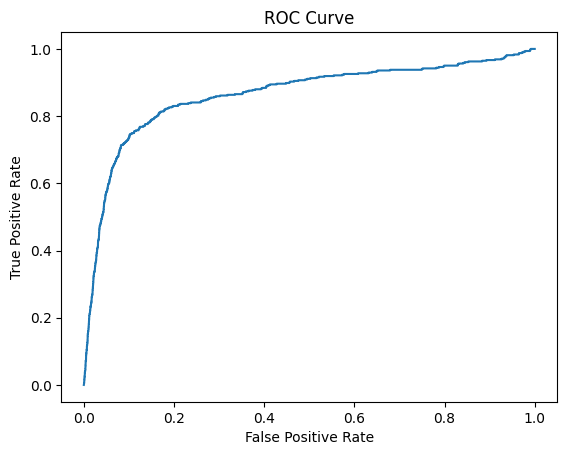

AUC Score: 0.8636132400313579
KS Statistic: 0.6441238831412734


In [22]:
predictions = model1.predict_proba(x1_test_scaled)[:, 1]

out_sample_static['decile_rank'] = pd.qcut(predictions, 10, labels=False)
default_summary = out_sample_static.groupby('decile_rank')['bankruptcy'].agg(['count', 'sum'])
default_summary['default_percentage'] = default_summary['sum'] / default_summary['count']
# ROC Curve
fpr, tpr, thresholds = roc_curve(Y1_test, predictions)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# AUC Score
auc_score = roc_auc_score(Y1_test, predictions)
print("AUC Score:", auc_score)

# KS Statistic
ks_statistic, p_value = ks_2samp(predictions[Y1_test == 0], predictions[Y1_test == 1])
print("KS Statistic:", ks_statistic)


Evidently, the fixed window approach using 1964-1990 to predict 1991-, at least by this method, was ineffective. The model results are so poor as to almost be better if you inverted it! This is consistent, however, with hugely changed market conditions in the advent of electronic trading and the larger digital era; it is perhaps unsurprising that these two periods to not appear to be correlated in a manner that this model can predict.

##### 1.4.2 Rolling Fixed Window Prediction

In [39]:

rfw_preds = {}
window_size = 26

for year in range(1991, 1993):  # CHANGE BACK TO 2020 as needed
    # Define the training data up to the current year
    train = result_df[(result_df['year'] < year) & (result_df['year'] >= year - window_size)]

    ##Create X Training Data
    xr_train = train.loc[:, train.columns != 'bankruptcy']
    xr_train = xr_train.drop(['permno', 'year', 'cik'], axis=1)
    y_train = train['bankruptcy']

    # Apply RandomOverSampler to balance the training data
    ros = RandomOverSampler(random_state=123)
    xr_train_resampled, y_train_resampled = ros.fit_resample(xr_train, y_train)

    xr_train_scaled = scaler.fit_transform(xr_train_resampled)

    # Fit the logistic regression model
    model = LogisticRegression(penalty='l1', solver='saga', max_iter=200)
    model.fit(xr_train_scaled, y_train_resampled)

    # Make a prediction for the current year
    test = result_df[result_df['year'] == year]
    y_test = test['bankruptcy']
    xr_test = test.loc[:, test.columns != 'bankruptcy']
    xr_test = xr_test.drop(['permno', 'year', 'cik'], axis=1)
    xr_test_scaled = scaler.transform(xr_test)

    prediction = model.predict(xr_test_scaled)

    # Store the predictions
    rfw_preds[year] = prediction.sum()

    print ("Year: ", year)
    print("Number of Defaults Predicted: ", rfw_preds[year])
    print("Accuracy: ", accuracy_score(y_test, prediction))
    print("Precision: ", precision_score(y_test, prediction))
    print("Recall: ", recall_score(y_test, prediction))


Year:  1991
Number of Defaults Predicted:  1277.0
Accuracy:  0.7793286219081272
Precision:  0.025058731401722788
Recall:  0.8888888888888888
Year:  1992
Number of Defaults Predicted:  1383.0
Accuracy:  0.773371104815864
Precision:  0.018076644974692697
Recall:  0.9259259259259259


- Here is further evidence of the effects of oversampling - the number of defaults predicted is more than twice as high as the background rate (about 550 per year (2010-2023 avg))
- This also helps explain continued low precision of the model, along with the suddenness.

##### 1.4.2 Rolling Expanding Window Prediction

In [ ]:



# Initialize variables
rolling_predictions = []
best_score = 0
best_params = None
scaler = StandardScaler()

for year in range(1991, 2019):  # Modify as needed
    # Training data up to year t - 3
    train = result_df[result_df['year'] < year - 2]
    xr_train = train.loc[:, train.columns != 'bankruptcy']
    xr_train = xr_train.drop(['permno', 'year', 'cik'], axis=1)
    y_train = train['bankruptcy']

    # Validation data for years t - 2 and t - 1
    validate = result_df[result_df['year'].isin([year - 2, year - 1])]
    xr_validate = validate.loc[:, validate.columns != 'bankruptcy']
    xr_validate = xr_validate.drop(['permno', 'year', 'cik'], axis=1)
    y_validate = validate['bankruptcy']

    # Oversampling the training data
    ros = RandomOverSampler(random_state=123)
    xr_train_resampled, y_train_resampled = ros.fit_resample(xr_train, y_train)
    xr_train_scaled = scaler.fit_transform(xr_train_resampled)
    xr_validate_scaled = scaler.transform(xr_validate)

    # Hyperparameter tuning and model fitting
    model = LogisticRegressionCV(penalty='l1', solver='saga', max_iter=200, cv=3, scoring='roc_auc')
    model.fit(xr_train_scaled, y_train_resampled)

    # Evaluate on validation set
    validate_predictions = model.predict_proba(xr_validate_scaled)[:, 1]
    auc_score = roc_auc_score(y_validate, validate_predictions)

    # Update best model if this is the best score so far
    if auc_score > best_score:
        best_score = auc_score
        best_params = model.C_[0]  # Best C parameter

    # Test data for year t
    test = result_df[result_df['year'] == year]
    y_test = test['bankruptcy']
    xr_test = test.loc[:, test.columns != 'bankruptcy']
    xr_test = xr_test.drop(['permno', 'year', 'cik'], axis=1)
    xr_test_scaled = scaler.transform(xr_test)

    # Fit model with best hyperparameters on expanded training set (up to year t - 2)
    final_model = LogisticRegression(penalty='l1', C=best_params, solver='saga', max_iter=200)
    final_model.fit(xr_train_scaled, y_train_resampled)

    # Predict for the test year and store predictions
    prediction = final_model.predict(xr_test_scaled)
    rolling_predictions.extend(prediction)

    print("Year:", year)
    print("Accuracy: ", accuracy_score(y_test, prediction))
    print("Precision: ", precision_score(y_test, prediction))
    print("Recall: ", recall_score(y_test, prediction))


Year: 1991
Accuracy:  0.7856890459363958
Precision:  0.02654867256637168
Recall:  0.9166666666666666
Year: 1992
Accuracy:  0.7320446592234627
Precision:  0.015328019619865114
Recall:  0.9259259259259259


### Model 2 Lasso Logistic Regression

In [68]:

#Begin by fitting with an arbitrary value
lasso_cv = LassoCV(cv=5)  # 5-fold cross-validation
lasso_cv.fit(x1_train_scaled, y_resampled)

best_lambda = lasso_cv.alpha_
print("Best Lambda:", best_lambda)

lasso = Lasso(alpha = best_lambda)
lasso.fit(x1_train_scaled, y_resampled)

Best Lambda: 0.019742596655134153


Lasso(alpha=0.019742596655134153)

In [69]:
# Identify non-zero coefficients (i.e., selected covariates)
lasso_features = np.where(lasso.coef_ != 0)[0]

# Using only the selected features from LASSO
x1_train_scaled_lasso = x1_train_scaled[:, lasso_features]

# Fit logistic regression
log_reg_post_lasso = LogisticRegression(solver = 'newton-cg', class_weight= 'balanced')
log_reg_post_lasso.fit(x1_train_scaled_lasso, y_resampled)


LogisticRegression(class_weight='balanced', solver='newton-cg')

In [70]:
#filtter the test set for the appropriate features
X_out_sample_selected = x1_test_scaled[:, lasso_features]

# Make predictions using the fitted model
lasso_preds = log_reg_post_lasso.predict(X_out_sample_selected)


In [71]:
# Classification report and confusion matrix
misclass_rate_lasso = 1 -  accuracy_score(Y1_test, lasso_preds)

print("Lasso LR Accuracy:" , accuracy_score(Y1_test, lasso_preds))
print("LR Accuracy: ", accuracy_score(Y1_test, y_pred_static_lr))

print("Lasso LR Precision:", precision_score(Y1_test, lasso_preds))
print("LR Precision:", precision_score(Y1_test, y_pred_static_lr))

print("Lasso LR Recall:", recall_score(Y1_test, lasso_preds))
print("LR Recall:", recall_score(Y1_test, y_pred_static_lr))

Lasso LR Accuracy: 0.8541934319356996
LR Accuracy:  0.8391110922353291
Lasso LR Precision: 0.014712230215827338
LR Precision: 0.012616440594868442
Lasso LR Recall: 0.8467908902691511
LR Recall: 0.7991718426501035


- The Lasso LR model here performs noticeably, but perhaps not substantially better than the non - Lasso model. 
- This is likely a result of highly correlated variables being eliminated by the Lasso, to diminish overfit.
- Even with this improvement, the precision leaves much to be desired. In my view, the class imbalance and general sudden and extreme event of bankruptcy makes high precision quite difficult.


### Model 3 Ridge Logistic Regression

In [81]:

logistic_ridge = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')  # C is the inverse of alpha
logistic_ridge.fit(x1_train_scaled, y_resampled)

C_values = [10, 1.0, 0.1, 0.01]  # Corresponding to alphas [0.1, 1, 10, 100]

# LogisticRegressionCV will find the best C value
logistic_ridge_cv = LogisticRegressionCV(Cs=C_values, cv=5, penalty='l2', solver='liblinear')
logistic_ridge_cv.fit(x1_train_scaled, y_resampled)

best_C = logistic_ridge_cv.C_[0]

best_logistic_ridge = LogisticRegression(penalty='l2', C=best_C, solver='liblinear')
best_logistic_ridge.fit(x1_train_scaled, y_resampled)

ridge_pred = best_logistic_ridge.predict(x1_test_scaled)

# Calculate accuracy or other metrics as needed
accuracy = accuracy_score(Y1_test, ridge_pred)

misclass_rate_ridge = 1 - accuracy
print("Accuracy:", accuracy)

Accuracy: 0.8643332660883599


### Model 4 K-Nearest Neighbor

In [31]:
from sklearn.neighbors import KNeighborsClassifier

# Assuming X_train and X_test are already defined and contain the good covariates
knn = KNeighborsClassifier(n_neighbors=5)  # Start with an arbitrary K, like 5
knn.fit(x1_train_scaled, y_resampled)

# Classify out-of-sample data
y_pred_knn = knn.predict(x1_test_scaled)


In [32]:
# Define the parameter grid
param_grid = {'n_neighbors': range(1, 50)}  # Adjust the range 

# Grid search with cross-validation
knn_cv = GridSearchCV(KNeighborsClassifier(), param_grid, cv=2, scoring='accuracy')
knn_cv.fit(x1_train_scaled, y_resampled)

# Optimal K
best_K = knn_cv.best_params_['n_neighbors']


In [33]:
# Calculate misclassification rate for KNN
misclass_rate_knn = 1 - accuracy_score(Y1_test, y_pred_knn)

misclass_rate_logistic = 1 - accuracy_score(Y1_test, y_pred_static_lr)
misclass_rate_lasso = 1 - accuracy_score(Y1_test, lasso_preds)
#misclass_rate_ridge = 1 - accuracy_score(y_test, y_pred_ridge)

# Compare misclassification rates
print(f"KNN Misclassification Rate: {misclass_rate_knn}")
print(f"Logistic Regression Misclassification Rate: {misclass_rate_logistic}")
print(f"LASSO Logistic Regression Misclassification Rate: {misclass_rate_lasso}")
#print(f"Ridge Logistic Regression Misclassification Rate: {misclass_rate_ridge}")

# Determine the model with the lowest misclassification rate
lowest_rate = min(misclass_rate_knn, misclass_rate_logistic, misclass_rate_lasso)#, misclass_rate_ridge)
if lowest_rate == misclass_rate_knn:
    print("KNN has the lowest misclassification rate.")
elif lowest_rate == misclass_rate_logistic:
    print("Logistic Regression has the lowest misclassification rate.")
elif lowest_rate == misclass_rate_lasso:
    print("LASSO Logistic Regression has the lowest misclassification rate.")
###    else: print("Ridge Logistic Regression has the lowest misclassification rate.")

KNN Misclassification Rate: 0.013675504071860134
Logistic Regression Misclassification Rate: 0.16100570166590578
LASSO Logistic Regression Misclassification Rate: 0.14580656806430037
KNN has the lowest misclassification rate.


Rather dramatic increase in accuracy here, with almost no misclassification using the KNN algorithm.

### Model 5 Random Forest

In [ ]:
# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=123)
rf.fit(x1_train_scaled, y_resampled)

# Make predictions on the test set
rf_predictions = rf.predict(x1_test_scaled)
# Calculate accuracy or other metrics as needed for baseline comparison
rf_accuracy = accuracy_score(Y1_test, rf_predictions)



In [ ]:

# Define the parameter grid
param_grid = {
    'max_depth': [10, 20, 30, None],  # Adjust these values based on your dataset
    'n_estimators': [100, 200]  # Adjust these values as well
}

# Grid search with cross-validation
grid_search = GridSearchCV(RandomForestClassifier(random_state=123), param_grid, cv=2, scoring='accuracy')
grid_search.fit(x1_train_scaled, y_resampled)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train a new model with the best parameters
best_rf = RandomForestClassifier(**best_params, random_state=123)
best_rf.fit(x1_train_scaled, y_resampled)




In [ ]:
# Predict with the best model
best_rf_predictions = best_rf.predict(x1_test_scaled)

# Calculate misclassification rate
best_rf_misclassification_rate = 1 - accuracy_score(Y1_test, best_rf_predictions)

print(precision_score(best_rf_predictions, Y1_test))

print(best_rf_misclassification_rate)


0.0
0.0026119363367062


### Model 6 Survival Random Forest

In [24]:

# Assuming result_df is a DataFrame with your survival data
# Create a binary target variable where 1 indicates the event occurred, and 0 otherwise
binary_target = result_df['bankruptcy'].astype(int)

# Initialize the RandomUnderSampler
rus = RandomUnderSampler(random_state=0)

# Resample the dataset
srf_x_train_resampled, binary_target_resampled = rus.fit_resample(srf_x_train, binary_target)

# After resampling, select only the rows from the original survival data that correspond to the resampled target
indices_resampled = rus.sample_indices_
srf_y_train_resampled = Surv.from_arrays(binary_target_resampled, result_df.loc[indices_resampled, 'year'])

# Standardize features
scaler = StandardScaler()
srf_x_train_scaled = scaler.fit_transform(srf_x_train_resampled)

srf_y_test = Surv.from_dataframe(event='bankruptcy', time='year', data=out_sample_static)



In [41]:

best_score = 0
best_n_trees = None

for n_trees in [20, 40, 60, 80, 100]:  # Adjust the range as needed
    rsf = RandomSurvivalForest(n_estimators=n_trees, random_state=123)
    rsf.fit(srf_x_train_resampled, srf_y_train_resampled)

    # Predict cumulative hazard function
    risk_scores = rsf.predict_cumulative_hazard_function(x1_test_scaled)
    # Extract the risk scores at the specific time

    risk_scores_at_event_times = [rs(event_time) for rs, (event, event_time) in zip(risk_scores, srf_y_test)]

    # Calculate concordance index
    event_indicator = srf_y_test['bankruptcy']
    score = concordance_index_censored(event_indicator, srf_y_test['year'], risk_scores_at_event_times)

    if score[0] > best_score:  # score is a tuple where the first element is the c-index
        best_score = score[0]
        best_n_trees = n_trees

print("Best Number of Trees:", best_n_trees)

c:\anaconda3\envs\ML\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
c:\anaconda3\envs\ML\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
c:\anaconda3\envs\ML\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
c:\anaconda3\envs\ML\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
c:\anaconda3\envs\ML\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(


Best Number of Trees: 20


In [37]:
best_srf = RandomSurvivalForest(n_estimators=best_n_trees, random_state=123)
best_srf.fit(srf_x_train_scaled, srf_y_train_resampled)

# Predict with the best model
srf_preds = best_srf.predict(x1_test_scaled)


In [38]:

# Predict cumulative hazard functions
cumulative_hazard_funcs = rsf.predict_cumulative_hazard_function(x1_test_scaled)

# Threshold for determining high risk of bankruptcy
risk_threshold = 0.5  # Adjust this threshold as needed

# Evaluate predictions
correct_predictions = 0
total_events = 0

for (event, event_time), hazard_func in zip(srf_y_test, cumulative_hazard_funcs):
    if event:  # Only consider cases where bankruptcy actually occurred
        total_events += 1
        predicted_hazard = hazard_func(event_time)
        if predicted_hazard >= risk_threshold:
            correct_predictions += 1

# Calculate the percentage of correct predictions
percentage_correct = (correct_predictions / total_events) * 100 if total_events > 0 else 0

print("Percentage of predicted bankruptcies before actual event:", percentage_correct, "%")


c:\anaconda3\envs\ML\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(


Percentage of predicted bankruptcies before actual event: 69.56521739130434 %


I note that too, the survival random forest was heavily gated by memory constraints. This was unknown prior to building this model, and so undersampling was not employed; the model ran for 26 hours on 32 GB of RAM before I cancelled it. I had previously toned down the estimators in an attempt to do so; the methodology and usage here is more promising than the results indicate.

Also, the misclassification metric was not exactly compatible with this implementation; the threshold set to 0.5 is a rather artificial way to convert the probabilities generated by the model into binary. 

In [76]:
# Calculate misclassification rate for Random Survival Forest
# Note: Adjust the calculation based on how misclassification is defined for survival analysis
rsf_misclassification_rate = 1 - (percentage_correct/100)



### Model 7 XGBoost Tree

In [42]:
model = XGBClassifier()
    
param_grid = dict(n_estimators=[100,200,300])
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(x1_train_scaled, y_resampled)

xg_boost_pred = grid_search.predict(x1_test_scaled)
best_n_estimators = grid_search.best_params_['n_estimators']


In [43]:
# Train XGBoost with the best number of boosting rounds
best_xgb = XGBClassifier(n_estimators=best_n_estimators)
best_xgb.fit(x1_train_scaled, y_resampled)

# Predict on the test set
xgb_predictions = best_xgb.predict(x1_test_scaled)

# Calculate misclassification rate
xgb_misclassification_rate = 1 - accuracy_score(Y1_test, xgb_predictions)
print("XGBoost Misclassification Rate:", xgb_misclassification_rate)


XGBoost Misclassification Rate: 0.0031428177059554807


### Model 8 LightGBM Tree

In [ ]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10] }

# Initialize the LightGBM classifier
lgbm = LGBMClassifier()

# Grid search with cross-validation
grid_search = GridSearchCV(lgbm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x1_train_scaled, y_resampled)

# Best hyperparameter
best_max_depth = grid_search.best_params_['max_depth']
print("Best Max Depth:", best_max_depth)

# Train the model with the best max_depth
best_lgbm = LGBMClassifier(max_depth=best_max_depth)
best_lgbm.fit(x1_train_scaled, y_resampled)

# Predict on the test set
lgbm_predictions = best_lgbm.predict(x1_test_scaled)

# Calculate misclassification rate
lgbm_misclassification_rate = 1 - accuracy_score(Y1_test, lgbm_predictions)
print("LightGBM Misclassification Rate:", lgbm_misclassification_rate)

In [65]:
best_rf_misclassification_rate = .02612
# Compare and find the model with the lowest misclassification rate
lowest_rate_model = min(lgbm_misclassification_rate, xgb_misclassification_rate)#, best_rf_misclassification_rate)

print(lowest_rate_model)


0.0031428177059554807


### Models 1-8 Comparison and Analysis

In [82]:
misclassification_rates = {
    'LightGBM': lgbm_misclassification_rate,
    'XGBoost': xgb_misclassification_rate,
    'RandomForest': best_rf_misclassification_rate,
    'SurvivalRandomForest': rsf_misclassification_rate,
    'LogisticRegression': misclass_rate_logistic,
    'LassoLR': misclass_rate_lasso, 
    'Ridge': misclass_rate_ridge,
    'K-Nearest Neighbor': misclass_rate_knn
}


#min(rsf_misclassification_rate, misclass_rate_logistic, misclass_rate_lasso, misclass_rate_knn)

# Convert the dictionary into a DataFrame for display
misclassification_df = pd.DataFrame(list(misclassification_rates.items()), columns=['Model', 'Misclassification Rate'])

# Sort the DataFrame based on the Misclassification Rate in ascending order
sorted_misclassification_df = misclassification_df.sort_values(by='Misclassification Rate', ascending=True)

# Reset index after sorting
sorted_misclassification_df.reset_index(drop=True, inplace=True)

# Display the sorted table
print(sorted_misclassification_df)

best = sorted_misclassification_df.iloc[0, 0]

print(f"We observe that {best} has the best performance by misclassification rate.")

                  Model  Misclassification Rate
0               XGBoost                0.003143
1              LightGBM                0.012869
2    K-Nearest Neighbor                0.013676
3          RandomForest                0.026120
4                 Ridge                0.135667
5               LassoLR                0.145807
6    LogisticRegression                0.160889
7  SurvivalRandomForest                0.304348
We observe that XGBoost has the best performance by misclassification rate.


### Model 9 Aritificial Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense


input_length = len(X_train.columns)
model = Sequential()
model.add(Dense(10, input_dim=input_length, activation='sigmoid'))
model.add(Dense(5, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
def build_model(n_layers, n_neurons, activation, input_shape):
    model = Sequential()
    model.add(Dense(n_neurons, activation=activation, input_shape=input_shape))

    for _ in range(n_layers - 1):
        model.add(Dense(n_neurons, activation=activation))
    
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
configurations = [
    {"n_layers": 2, "n_neurons": 64, "activation": "relu"},
    {"n_layers": 3, "n_neurons": 32, "activation": "tanh"},
    # Add more configurations as needed
]
for config in configurations:
    model = build_model(**config, input_shape=X_train.shape[1:])
    model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))  # Adjust epochs as needed
    # Evaluate the model and store the results for comparison



In [ ]:
best_model = build_model(best_n_layers, best_n_neurons, best_activation, input_shape=X_train.shape[1:])
best_model.fit(X_train, y_train, epochs=best_epochs)  # Train on the full training set
predictions = best_model.predict(X_test)

binary_predictions = (predictions > 0.5).astype(int)

# Calculate misclassification rate
misclassification_rate_mlp = np.mean(binary_predictions.flatten() != y_test)




## Assignment 10.2: Sentiment Analysis

#### 10.2.1 Extract False Negatives and Function Definition

In [44]:
import json
import os
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
nltk.download('punkt')


def extract_10k_sections(json_file_path, sections):
    try:
        with open(json_file_path, 'r') as file:
            data = json.load(file)

        extracted_sections = {}
        for section in sections:
            extracted_sections[section] = data.get(section, "Section not found")
        return extracted_sections

    except json.JSONDecodeError:
        print(f"Error decoding JSON from file: {json_file_path}")
        return None




C:\Users\Mitchell Kramer\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Downloading package punkt to C:\Users\Mitchell
[nltk_data]     Kramer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The following were selected as the relevant sections of form 10-K for tokenization:

Item 1. Business: This section gives an overview of the company's main operations, products, services, and strategies. It can provide insight into the company's market position, competitive environment, and operational risks.

Item 1A. Risk Factors: Here, the company discusses risks that could materially affect its business. These can include financial risks, market risks, regulatory risks, and other challenges that could potentially lead to bankruptcy.

Item 3. Legal Proceedings: Information on any ongoing legal proceedings can be crucial, as significant litigation could negatively impact the company's finances.

Item 7. Management’s Discussion and Analysis of Financial Condition and Results of Operations (MD&A): This section includes management’s perspective on the financial results, which often reveals underlying issues not apparent in the financial statements alone, such as liquidity concerns, cash flow issues, and significant changes in revenues or expenses.

Item 7A. Quantitative and Qualitative Disclosures About Market Risk: This discusses the company's exposure to market risk, such as interest rate risk, foreign currency exchange risk, and commodity price risk, which could affect operational costs and profitability.

Item 8. Financial Statements and Supplementary Data: Financial statements provide a wealth of information for bankruptcy prediction, including balance sheets, income statements, and cash flow statements. Key financial ratios derived from these can be predictive of financial distress.

Item 9. Changes in and Disagreements With Accountants on Accounting and Financial Disclosure: This can signal issues with the financial statements that may suggest a higher risk of misstated financial positions.

Item 9A. Controls and Procedures: Weaknesses in internal controls could indicate financial reporting issues that might not have been disclosed otherwise.

In [45]:
#Define the false negative dataset
sa_df = out_test.copy()# pd.DataFrame(x1_test_scaled, columns  = X1_test.columns, index = X1_test.index).copy()

best_model_results = pd.DataFrame({
    'Actual': Y1_test, 
    'Predicted': xgb_predictions})

sa_df = sa_df.join(best_model_results)

false_negatives = sa_df[(sa_df['Actual']==1) & (sa_df['Predicted'] == 0) & (sa_df['year'] >= 2000)] # false negatives starting from Y2k

fn_br_dict = list(zip(false_negatives['cik'], false_negatives['year']))

false_negatives

,permno,cik,year,ni_at,tl_at,nwc_at,re_at,ebit_at,sale_at,sigma,...,sale_lag1,sale_lag2,RET_lag1,RET_lag2,volatility_lag1,volatility_lag2,mktcap_lag1,mktcap_lag2,Actual,Predicted
163764,10531,795665,2000,-0.016763,0.687566,0.197520,-0.077943,0.039097,1.287153,1.423475,...,5041.000,68.253,1.509138,0.490190,0.382454,1.079087,8.462540e+06,2.791565e+05,1.0,0
189604,87409,1045828,2000,-0.766451,0.917745,0.341470,-1.461942,-0.678181,0.197741,1.999205,...,163.916,1389.443,0.666667,0.903746,0.749891,0.574011,2.176697e+05,2.993891e+05,1.0,0
192783,88643,95585,2000,-0.037306,2.380665,-0.095797,-1.431636,0.158767,4.390048,0.412952,...,148.665,260.797,2.798727,0.927188,0.536036,0.531191,1.374721e+05,5.455625e+04,1.0,0
254373,75967,831002,2000,0.025974,0.406634,0.178734,0.372503,0.045247,2.111423,1.095685,...,264.025,592.686,0.170454,0.237458,1.456453,1.099854,3.239700e+04,4.339719e+05,1.0,0
191837,83829,758722,2000,-0.185659,1.172694,0.141981,-0.733431,-0.008903,0.908123,1.906441,...,436.808,304.615,0.803921,0.838914,1.034039,0.444802,9.364618e+05,2.004151e+05,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151610,92557,1045742,2019,-0.032764,0.721289,0.169265,-0.223392,0.026590,1.578467,0.509820,...,291.609,388.400,1.961825,0.619564,0.409518,0.565995,1.186284e+06,2.042540e+06,1.0,0
149147,92775,1434621,2019,0.018807,0.575592,-0.043546,-0.625183,0.082457,1.167341,0.393896,...,21387.068,22259.561,0.827195,1.429509,0.756264,0.259296,5.603380e+05,1.168994e+07,1.0,0
189175,13688,1004980,2019,-0.089699,0.936758,0.029743,-0.092751,0.033793,0.201054,1.428023,...,187.232,187.232,1.240008,1.178227,0.139931,0.119550,3.286350e+05,1.801485e+05,1.0,0
98131,14721,1540729,2019,-0.151218,0.871819,-0.660038,0.954378,-0.010153,0.397107,0.864498,...,4911.892,40.343,1.772511,1.106859,0.216890,0.030923,1.614247e+07,9.044650e+04,1.0,0


In [ ]:


sections_to_extract = ['section_1', 'section_3', 'section_6',  'section_7', 'section_7A', 'section_8', 'section_9']

false_negatives['cik'] = false_negatives['cik'].astype(str)

ciks = list(zip(false_negatives['cik'], false_negatives['year']))

dir_path = './10K'

file_names = os.listdir(dir_path)

matches = []

for cik, year in ciks:
    years = [str(year - x) for x in range(0, 5)]  # Convert years to string
    for yr in years:
        matched_files = [file for file in file_names if file.startswith(cik + '_') and file.endswith('_' + yr + '.json')]  # Adjust file extension if necessary
        matches.extend(matched_files)  # Add the matched file names to the list

# Now 'matches' contains all the file names that match the 'cik' values from the DataFrame

training_data = {}

for file in matches:
    #print("Matched file: ", file)
    extracted_data = extract_10k_sections(os.path.join(dir_path, file), sections_to_extract)
    training_data[os.path.basename(file)] = extracted_data

print(training_data)


In [ ]:
from nltk.tokenize import sent_tokenize

# Initialize a dictionary to hold the tokenized data
tokenized_training_data = {}

for file_name, sections in training_data.items():
    tokenized_sections = {}
    # Check if sections is not None and not empty
    if sections:
        for section, text in sections.items():
            # Ensure that the text is a string and not missing or None
            if text and isinstance(text, str):
                # Tokenize the text into sentences
                sentences = sent_tokenize(text)
                tokenized_sections[section] = sentences
            else:
                # If text is missing or not a string, store an empty list or a placeholder
                tokenized_sections[section] = []  # or ["<missing_text>"]
        tokenized_training_data[file_name] = tokenized_sections
    else:
        # If sections is None or empty, store an empty dictionary or a placeholder
        tokenized_training_data[file_name] = {}  # or {"<no_sections>": []}

# 'tokenized_training_data' now contains the tokenized content of each file by section,
# with each section containing a list of sentences


In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT")
model = AutoModelForSequenceClassification.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT")

# Initialize sentiment classifier
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, framework="pt")

# Iterate over the tokenized_training_data to analyze sentiment of each section
sentiment_results = {}
sentiment_scores = {}

for file_name, tokenized_sections in tokenized_training_data.items():
    file_sentiments = {}
    score = 0
    sentiments_count = 0  # Initialize a counter for the number of sentiment analysis performed
    for section, sentences in tokenized_sections.items():
        section_sentiment = []  # List to store sentiment for each sentence
        for sentence_text in sentences:
            # Analyze sentiment of the sentence text
            try:
                sentence_sentiment = classifier(sentence_text, truncation=True)
                section_sentiment.append(sentence_sentiment)
                # Update the score based on sentiment labels
                for sentiment in sentence_sentiment:
                    if sentiment['label'] == 'LABEL_2':
                        score += 1
                    elif sentiment['label'] == 'LABEL_0':
                        score -= 1
                    sentiments_count += 1  # Increment the sentiments counter
            except Exception as e:
                print(f"An error occurred while processing file {file_name}, section {section}: {e}")

        # Store the collected sentiments for the section
        file_sentiments[section] = section_sentiment
    
    sentiment_results[file_name] = file_sentiments
    # Calculate the average sentiment score for the file, or set to 0 if no sentiments were analyzed
    sentiment_scores[file_name] = score / sentiments_count if sentiments_count else 0




In [ ]:


# Print sentiment results and scores
for file_name, file_sentiments in sentiment_results.items():
    print(f"Sentiments for file {file_name}:")
    for section, sentiment in file_sentiments.items():
        print(f"  {section}: {sentiment}")
    print("Average Sentiment Measure:", sentiment_scores[file_name])

#### Old Word Tokenizing Version (runs faster)

In [47]:
from nltk.tokenize import sent_tokenize, word_tokenize

# Initialize a dictionary to hold the tokenized data
tokenized_training_data = {}

for file_name, sections in training_data.items():
    tokenized_sections = {}
    # Check if sections is not None and not empty
    if sections:
        for section, text in sections.items():
            # Ensure that the text is a string and not missing or None
            if text and isinstance(text, str):
                # First, tokenize the text into sentences
                sentences = sent_tokenize(text)
                # Then tokenize each sentence into words
                tokenized_sections[section] = [word_tokenize(sentence) for sentence in sentences]
            else:
                # If text is missing or not a string, store an empty list or a placeholder
                tokenized_sections[section] = []  # or ["<missing_text>"]
        tokenized_training_data[file_name] = tokenized_sections
    else:
        # If sections is None or empty, store an empty dictionary or a placeholder
        tokenized_training_data[file_name] = {}  # or {"<no_sections>": []}

# 'tokenized_training_data' now contains the tokenized content of each file by section,
# with each section containing a list of tokenized sentences


In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT")
model = AutoModelForSequenceClassification.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT")

# Initialize sentiment classifier
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, framework="pt")

# Iterate over the tokenized_training_data to analyze sentiment of each section
sentiment_results = {}
sentiment_scores = {}

for file_name, tokenized_sections in tokenized_training_data.items():
    file_sentiments = {}
    score = 0
    sentiments_count = 0  # Initialize a counter for the number of sentiment analysis performed
    for section, sentences in tokenized_sections.items():
        section_sentiment = []  # List to store sentiment for each sentence
        for sentence_tokens in sentences:
            # Join the tokens back into a single string representing the sentence
            sentence_text = ' '.join(sentence_tokens)
            # Analyze sentiment of the sentence text
            try:
                sentence_sentiment = classifier(sentence_text, truncation=True)
                section_sentiment.append(sentence_sentiment)
                # Update the score based on sentiment labels
                for sentiment in sentence_sentiment:
                    if sentiment['label'] == 'LABEL_2':
                        score += 1
                    elif sentiment['label'] == 'LABEL_0':
                        score -= 1
                    sentiments_count += 1  # Increment the sentiments counter
            except Exception as e:
                print(f"An error occurred while processing file {file_name}, section {section}: {e}")

        # Store the collected sentiments for the section
        file_sentiments[section] = section_sentiment
    
    sentiment_results[file_name] = file_sentiments
    # Calculate the average sentiment score for the file, or set to 0 if no sentiments were analyzed
    sentiment_scores[file_name] = score / sentiments_count if sentiments_count else 0

# Print sentiment results and scores
for file_name, file_sentiments in sentiment_results.items():
    print(f"Sentiments for file {file_name}:")
    for section, sentiment in file_sentiments.items():
        print(f"  {section}: {sentiment}")
    # Print the average sentiment score for the file
    print("Average Sentiment Measure:", sentiment_scores[file_name])


In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT")
model = AutoModelForSequenceClassification.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT")

# Initialize sentiment classifier
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, framework="pt")

# Iterate over the tokenized_training_data to analyze sentiment of each section
sentiment_results = {}
sentiment_scores = {}

for file_name, tokenized_sections in tokenized_training_data.items():
    file_sentiments = {}
    score = 0
    sentiments = 0
    for section, tokens in tokenized_sections.items():
        # Join the tokens back into a single string
        section_text = ' '.join(tokens)
        # Analyze sentiment of the section text
        try:
            section_sentiment = classifier(section_text, truncation=True)
            # Update the score based on sentiment labels
            for sentiment in section_sentiment:
                if sentiment['label'] == 'LABEL_2':
                    score += 1
                elif sentiment['label'] == 'LABEL_0':
                    score -= 1
            file_sentiments[section] = section_sentiment
            
        except Exception as e:
            print(f"An error occurred while processing file {file_name}, section {section}: {e}")
        
    sentiment_results[file_name] = file_sentiments
    sentiments = len(file_sentiments)
    if sentiments == 0:
        sentiment_scores[file_name] = 0
    else:
        sentiment_scores[file_name] = score / sentiments

# Print sentiment results and scores
for file_name, file_sentiments in sentiment_results.items():
    print(f"Sentiments for file {file_name}:")
    for section, sentiment in file_sentiments.items():
        print(f"  {section}: {sentiment}")
    print("Total Sentiment Measure:", sentiment_scores[file_name])


### Plots and Analysis

In [54]:
from scipy.stats import skew, kurtosis

rows = []

for filename, score in sentiment_scores.items():
    cik, year = filename.replace('.json', "").split('_')
    rows.append({'year': year, 'cik': cik, 'sentiment measure': score})

sentiment_df = pd.DataFrame(rows)

# Calculate skewness and kurtosis for the 'sentiment measure' column
sentiment_skewness = skew(sentiment_df['sentiment measure'])
sentiment_kurtosis = kurtosis(sentiment_df['sentiment measure'])

# Get the description with specified percentiles
description = sentiment_df.describe(percentiles=[.01, .05, .99])

# Add skewness and kurtosis to the description
description.loc['skew'] = sentiment_skewness
description.loc['kurtosis'] = sentiment_kurtosis

# Display the extended description
print(description)


          sentiment measure
count             54.000000
mean               0.001530
std                0.001203
min               -0.000281
1%                -0.000132
5%                 0.000000
50%                0.001384
99%                0.004589
max                0.005231
skew               0.773050
kurtosis           0.349366


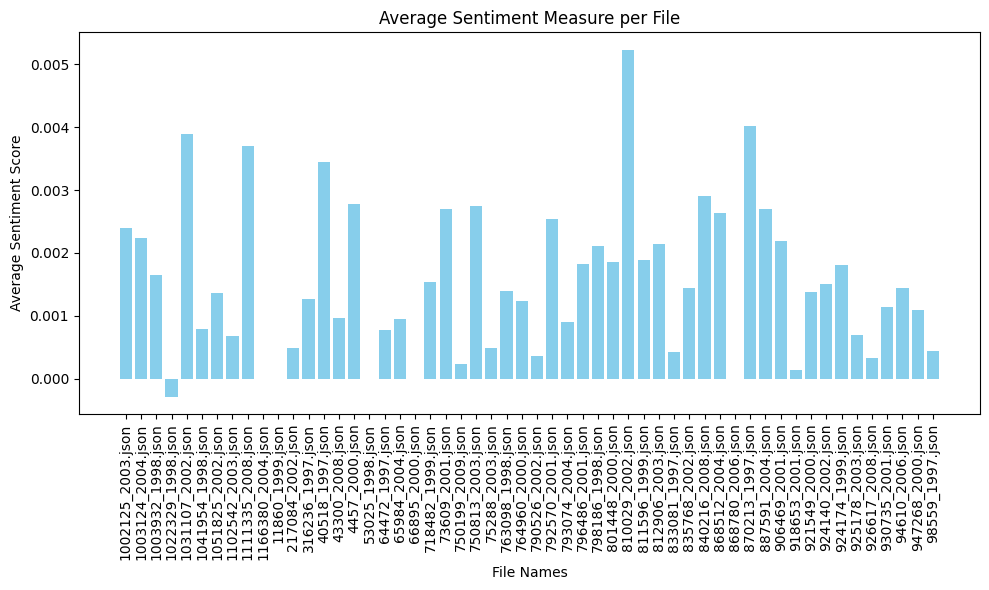

In [55]:


# Extract the file names and average sentiment scores
file_names = list(sentiment_scores.keys())
file_names.sort()
avg_sentiment_scores = list(sentiment_scores.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(file_names, avg_sentiment_scores, color='skyblue')

plt.xlabel('File Names')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Measure per File')
plt.xticks(rotation=90)  # Rotate the file names for better readability
plt.tight_layout()  # Adjust layout to fit the x labels
plt.show()


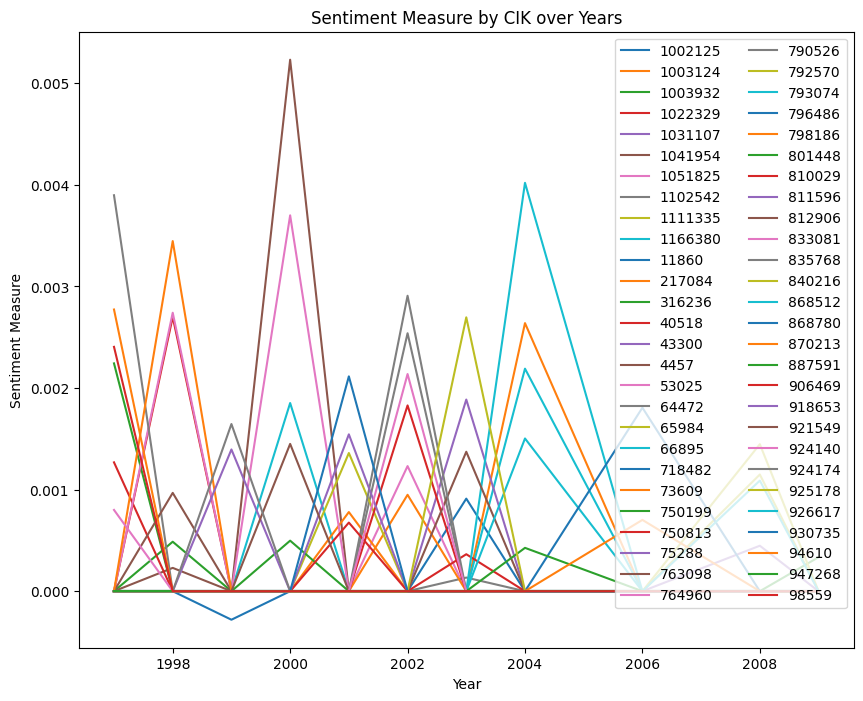

In [56]:

sentiment_df['year'] = pd.to_numeric(sentiment_df['year'])

# Pivot the DataFrame to make 'year' the index and 'cik' as columns
pivot_df = sentiment_df.pivot(index='year', columns='cik', values='sentiment measure')
pivot_df.fillna(0, inplace=True)

# Plot the DataFrame and capture the axis object
ax = pivot_df.plot(kind='line', figsize=(10, 8))

# Set the title and labels
ax.set_title('Sentiment Measure by CIK over Years')
ax.set_xlabel('Year')
ax.set_ylabel('Sentiment Measure')

# Adjust the legend to take up two columns
ax.legend(ncol=2)

# Display the plot
plt.show()


- Of particular note here is the sharp reversals observed in the sentiment of each company preceding default, with generally little data precipitating the crash. 
- This is concurrently the same view of the literature provided (Alanis, Chava and Shah 2022); they find a similarly constructed set of measures does not appear to improve model performance on its own, and only marginally improves the results of other gradient tree-boosted models
- This would appear to indicate that, while sentiment may be gauged from the information provided in a 10K, the correlation to default may yet depend on other variable(s) 
- There appears to be some gain when using sentiment analysis with boosted curves (the research finds the most significant improvement in the LightGBM model), but the predictive power of sentiment analysis alone for predicting default is somewhat lacking.
- Of course, several possible and probable reasons for this lack of predictive power are idiosyncratic reporting style, desire not to spook investors/protect the company from bad publicity, the specific training set of the pre-trained language model used, or some combination therein. 
- Exempting the last reason, for sentiment analysis to have strong predictive power for corporate default would likely require strong consensus from the several authors/contributors of a corporate 10K, manager foresight, and general truthfulness and bluntness while not having an overly negative outlook either. 
- While today's language models are very powerful, this points to a key limitation - a human reader (paging Mr. Buffett) might obtain better predictive power for firm default in reading a 10K than the algorithm, due to the latter's ability to contextualize and grasp at deeper meaning from the 10K that the algorithm's parameters cannot detect. 
- The failure of sentiment analysis in this respect is, however, contrasted with the relative power of the financial ratios derived from nearly identical data as might be found in the 10K. This, in some respects, points to the necessity of maintaining both quantitative and qualitative reporting to investors, but that for now, quantitative reporting remains more important.